## Creating a CNN Model from scratch

[Tutorial on using Keras flow_from_directory and generators](https://medium.com/@vijayabhaskar96/tutorial-image-classification-with-keras-flow-from-directory-and-generators-95f75ebe5720)

[Keras training on large datasets](https://towardsdatascience.com/keras-a-thing-you-should-know-about-keras-if-you-plan-to-train-a-deep-learning-model-on-a-large-fdd63ce66bd2)

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [5]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator

In [6]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=( 150, 150, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

In [7]:
model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(10))
model.add(Activation('softmax'))

# parallel_model = multi_gpu_model(model, gpus=2)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 64)        18496     
__________

In [9]:
batch_size = 64

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        'data/train',  # this is the target directory
        target_size=(150, 150),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='categorical', 
        shuffle=True,
        seed = 42)  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        'data/validation',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical', 
        shuffle = True, 
        seed = 42)

Found 44000 images belonging to 10 classes.
Found 5000 images belonging to 10 classes.


In [12]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch=44000 // batch_size,
        epochs=3,
        validation_data=validation_generator,
        validation_steps=5000 // batch_size)

# always save your weights after training or during training
model.save_weights('first_try.h5') 


Epoch 1/3
687/687 [==============================] - 128s 187ms/step - loss: 0.4801 - acc: 0.8552 - val_loss: 0.2110 - val_acc: 0.9395
Epoch 2/3
687/687 [==============================] - 128s 186ms/step - loss: 0.3022 - acc: 0.9136 - val_loss: 0.1568 - val_acc: 0.9545
Epoch 3/3
687/687 [==============================] - 128s 186ms/step - loss: 0.2513 - acc: 0.9304 - val_loss: 0.1516 - val_acc: 0.9591


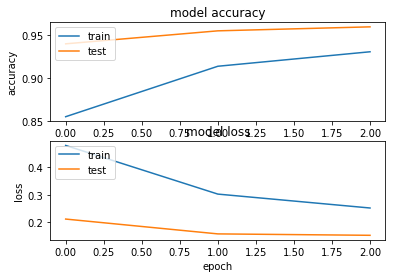

In [14]:
plt.figure(1)  

# summarize history for accuracy  

plt.subplot(211)  
plt.plot(history.history['acc'])  
plt.plot(history.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  

# summarize history for loss  

plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.show() 

In [16]:
model.evaluate_generator(generator=validation_generator)

[0.15135861373394727, 0.9592]

### Making the prediction for test dataset

In [15]:
test_generator = test_datagen.flow_from_directory(
    directory="data/test",
    target_size=(150, 150),
    batch_size=1,
    class_mode=None,
    shuffle=False,
    seed=42
)

Found 21000 images belonging to 1 classes.


In [17]:
test_generator.reset()
pred=model.predict_generator(test_generator,verbose=1)

21000/21000 [==============================] - 21s 998us/step


In [18]:
predicted_class_indices=np.argmax(pred,axis=1)

In [19]:
predicted_class_indices[:5]

array([4, 0, 9, 7, 9])

In [20]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())

In [21]:
predictions = [labels[k] for k in predicted_class_indices]

In [22]:
predictions[:5]

['4', '0', '9', '7', '9']

In [23]:
filenames=test_generator.filenames

In [25]:
results=pd.DataFrame({"filename":filenames,
                      "label":predictions})
results.to_csv("results/results_cnn_scratch.csv",index=False)